# Example: Center of Mass calculation

Prerequisites: 

 * a python3.6, python3.7 or python3.8 virtualenv with all requirements installed
  * LiberTEM 0.5.1 or newer
  * a HDF5 dataset

In [1]:
%matplotlib nbagg

In [2]:
from scipy.ndimage import measurements
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import h5py

from libertem import api

This starts a local cluster that is accessible through ``ctx``. Starting several clusters in parallel is unproblematic because each cluster is rather lightweight and relies on the host file system for caching.

In [3]:
ctx = api.Context()

If you want to run this notebook, you may need to adjust the ``emd_path`` variable and ``hdf5path`` parameter here. This example uses a local HDF5 file as input dataset.

In [4]:
emd_path = 'E:/LargeData/LargeData/ER-C-1/groups/data_science/data/reference/EMPAD/BiFeO3/scan_11_x256_y256.emd'
hdf5path = 'experimental/science_data/data'

ds = ctx.load(
    'hdf5',
    path=emd_path,
    ds_path=hdf5path,
)

# we could also use the new type="auto" feature:
# here, the ds_path is set automatically to the largest dataset in the HDF5 file
# ds = ctx.load('auth', path=emd_path)

(scan_y, scan_x, detector_y, detector_x) = ds.shape

Now, we create a center of mass (COM) analysis. We set the mask radius to `None` (default) to use the entire frame.

In [5]:
cx = detector_x/2
cy = detector_y/2
analysis = ctx.create_com_analysis(dataset=ds, cx=cx, cy=cy, mask_radius=None)

We kick off the computation:

In [6]:
%time result = ctx.run(analysis, progress=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.72it/s]


Wall time: 4.82 s


Let's show the result:

In [7]:
print(result)

[<AnalysisResult: field>, <AnalysisResult: magnitude>, <AnalysisResult: divergence>, <AnalysisResult: curl>, <AnalysisResult: x>, <AnalysisResult: y>]


In [8]:
print(result.field)

title: field
desc: cubehelix colorwheel visualization
key: field
raw_data: (array([[ 0.27875519, -0.39031982,  1.14976501, ..., -0.68854904,
        -0.80986023, -1.02923965],
       [ 0.30957794,  0.55505371,  0.95257568, ..., -0.77316284,
        -0.90735626, -1.11693192],
       [ 0.00857544,  0.21022797,  0.95464325, ..., -1.06136703,
        -1.30621338, -1.4584198 ],
       ...,
       [ 0.31816101,  1.00740051,  0.48000336, ...,  0.15503693,
         0.0266571 , -0.29507828],
       [ 0.63706207,  0.64839935, -0.16072845, ..., -0.05502319,
         0.01834869, -0.28865051],
       [ 0.46067047,  0.48744202, -0.56296539, ..., -0.29444885,
         0.23345184,  0.24785614]]), array([[-0.80866241, -0.90320969, -0.74656296, ..., -0.87127304,
        -0.50823593, -0.1940155 ],
       [-0.58219528, -0.7735939 , -1.31773758, ..., -1.52444839,
        -0.86785126, -0.57385254],
       [-0.6904335 , -0.92946625, -0.8849144 , ..., -1.9639473 ,
        -1.47749329, -0.93143845],
       ...

We show the default visualization for field and for magnitude.

<IPython.core.display.Javascript object>


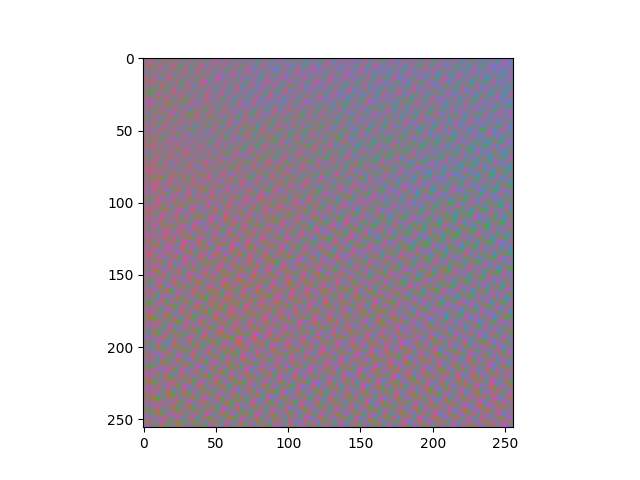

<IPython.core.display.Javascript object>


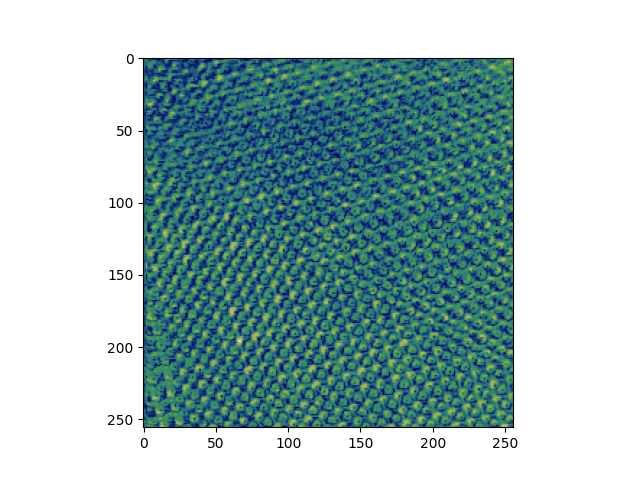

In [9]:
fig, axes = plt.subplots()
axes.imshow(result.field.visualized)
fig, axes = plt.subplots()
axes.imshow(result.magnitude.visualized)

We plot the underlying numerical data for x and y shift

<IPython.core.display.Javascript object>


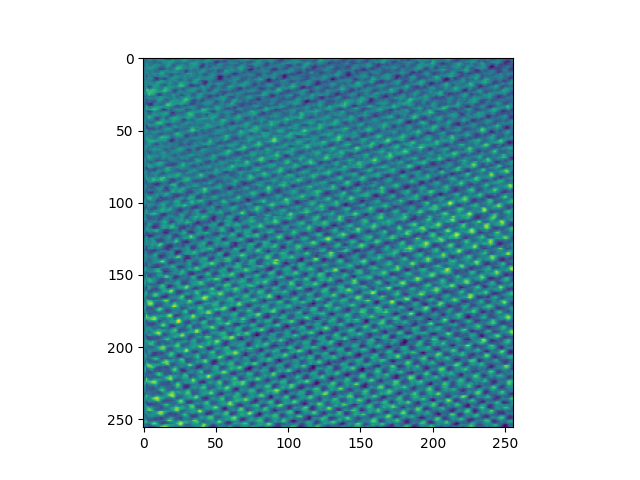

<IPython.core.display.Javascript object>


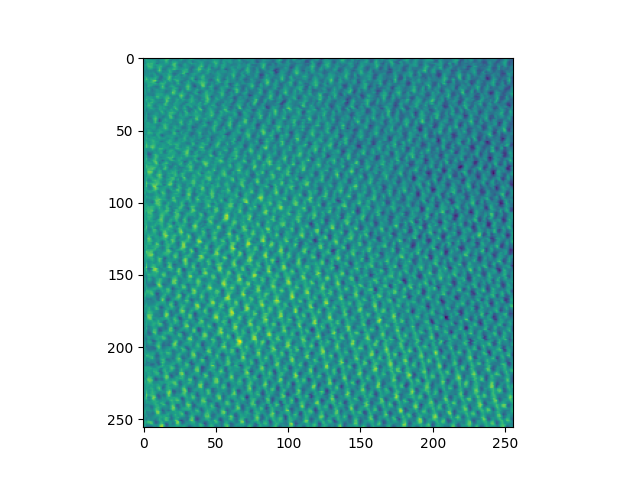

In [10]:
fig, axes = plt.subplots()
axes.imshow(result.y.raw_data)
fig, axes = plt.subplots()
axes.imshow(result.x.raw_data)

We load the upper left frame using picking and compare to the result from the HDF5 file

In [11]:
pick_a = ctx.create_pick_analysis(dataset=ds, y=0, x=0)
pick_res = ctx.run(pick_a)

h5 = h5py.File(emd_path)
raw_res = h5[hdf5path][0, 0]

np.allclose(pick_res.intensity.raw_data, raw_res)

True

We plot the frame

<IPython.core.display.Javascript object>


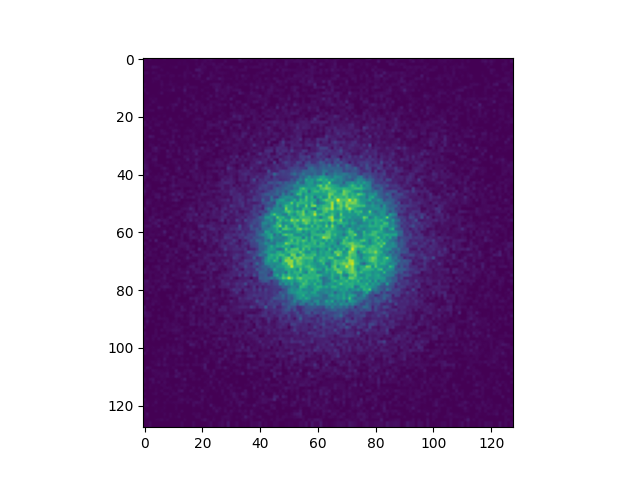

In [12]:
fig, axes = plt.subplots()
axes.imshow(pick_res.intensity.raw_data)

We confirm that the center of mass result matches the skimage result within numerical tolerances.
LiberTEM returns the deviation from the reference center while the function from scikit-image returns the center in image coordinates. Therefore we add the reference center to the LiberTEM result for comparison.

In [13]:
sk_result = measurements.center_of_mass(pick_res.intensity.raw_data)
lt_result = (result.y.raw_data[0, 0] + cy, result.x.raw_data[0, 0] + cx)

print(sk_result)
print(lt_result)

np.allclose(
    sk_result,
    lt_result
)

(63.191338347888035, 64.2787578604529)
(63.19133758544922, 64.27875518798828)


True